# USAD
## Importing packages

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

## Reading data

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
seed_num = 11884
set_seed(seed_num)

In [4]:
df = pd.read_csv('../../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')
grouping_array = np.arange(len(df)) // 5
df = df.groupby(grouping_array).median()

### Processing data

In [5]:
window_size = 12
input_size = window_size * 51
latent_space = 40
epochs = 70

In [6]:
mm = StandardScaler()

In [7]:
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda:0


In [9]:
#device = torch.device('cpu')

In [10]:
class SWat_dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, target: pd.DataFrame,  window_size):
        self.data = dataframe
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.window_size]
        features = torch.tensor(window.iloc[:,:].values).float().to(device)
        return features

In [11]:
train_dataset = SWat_dataset(train_set, train_set, window_size)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## Setting up the model structure

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, input_size // 2)
        self.relu = nn.ReLU(True)
        self.fc2 = nn.Linear(input_size // 2, input_size // 4)
        self.fc3 = nn.Linear(input_size // 4, hidden_size)
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        return out


class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, encoder):        
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(True)
        self.fc1 = nn.Linear(hidden_size, input_size // 4)
        self.fc2 = nn.Linear(input_size // 4, input_size // 2)
        self.fc3 = nn.Linear(input_size // 2, input_size)
        
    def forward(self, x):
        out = self.encoder(x)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [13]:
shared_encoder = Encoder(input_size, latent_space)
AE1 = AutoEncoder(input_size, latent_space, shared_encoder)
AE2 = AutoEncoder(input_size, latent_space, shared_encoder)

In [14]:
shared_encoder.to(device)
AE1.to(device)
AE2.to(device)

AutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=612, out_features=306, bias=True)
    (relu): ReLU(inplace=True)
    (fc2): Linear(in_features=306, out_features=153, bias=True)
    (fc3): Linear(in_features=153, out_features=40, bias=True)
  )
  (sigmoid): Sigmoid()
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=40, out_features=153, bias=True)
  (fc2): Linear(in_features=153, out_features=306, bias=True)
  (fc3): Linear(in_features=306, out_features=612, bias=True)
)

In [15]:
optimizer1 = torch.optim.Adam(AE1.parameters())
optimizer2 = torch.optim.Adam(AE2.parameters())

In [16]:
model_1 = 'AE1_downsampled_seed_' + str(seed_num) + '.pth'
model_2 = 'AE2_downsampled_seed_' + str(seed_num) + '.pth'

## Training the model

### Training

In [17]:
%%time
AE1_val_history = []
AE2_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    running_loss_AE2 = []
    val_loss_AE1 = []
    val_loss_AE2 = []
    for index_b, features in enumerate(train_loader):
        features = features.view(features.shape[0], -1)
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE2.append(lossAE2)
        lossAE2.backward()
        optimizer2.step()
        optimizer2.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():
            features = features.view(features.shape[0], -1)
        
            w1 = AE1(features)
            w2 = AE2(features)
            w3 = AE2(w1)
            lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            val_loss_AE1.append(lossAE1)
            val_loss_AE2.append(lossAE2)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    AE2_val_history.append(torch.stack(val_loss_AE2).mean().item())
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}, AE2: {AE2_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}, AE2 {torch.stack(running_loss_AE2).mean().item():.4f}')
torch.save(AE1.state_dict(), model_1)
torch.save(AE2.state_dict(), model_2)

Epoch: 0 ---> Val loss: AE1 0.2783, AE2: 0.2621
Train loss: AE1 0.5830, AE2 0.5644
Epoch: 1 ---> Val loss: AE1 0.2697, AE2: -0.0453
Train loss: AE1 0.3824, AE2 -0.0486
Epoch: 2 ---> Val loss: AE1 0.3272, AE2: -0.1649
Train loss: AE1 0.5783, AE2 -0.2691
Epoch: 3 ---> Val loss: AE1 0.3628, AE2: -0.2501
Train loss: AE1 0.7319, AE2 -0.5008
Epoch: 4 ---> Val loss: AE1 0.3761, AE2: -0.2959
Train loss: AE1 0.7584, AE2 -0.6241
Epoch: 5 ---> Val loss: AE1 0.3895, AE2: -0.3287
Train loss: AE1 0.7773, AE2 -0.6888
Epoch: 6 ---> Val loss: AE1 0.4002, AE2: -0.3525
Train loss: AE1 0.7873, AE2 -0.7195
Epoch: 7 ---> Val loss: AE1 0.4041, AE2: -0.3653
Train loss: AE1 0.7969, AE2 -0.7465
Epoch: 8 ---> Val loss: AE1 0.4103, AE2: -0.3755
Train loss: AE1 0.8096, AE2 -0.7668
Epoch: 9 ---> Val loss: AE1 0.4189, AE2: -0.3905
Train loss: AE1 0.8210, AE2 -0.7827
Epoch: 10 ---> Val loss: AE1 0.4173, AE2: -0.3922
Train loss: AE1 0.8261, AE2 -0.7950
Epoch: 11 ---> Val loss: AE1 0.4213, AE2: -0.3993
Train loss: AE1 

In [18]:
def plot_history(losses1, losses2):
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.savefig('Training_history.png')
    plt.show()

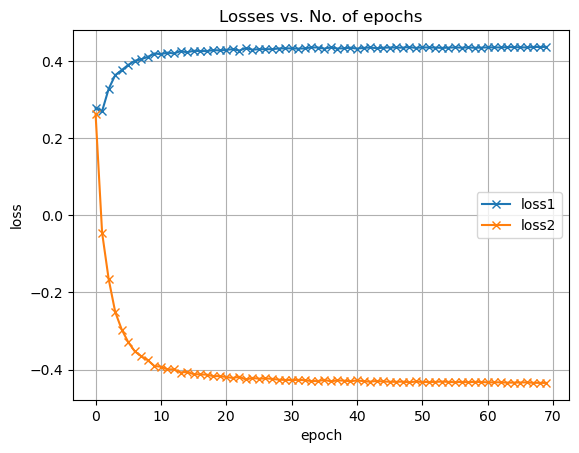

In [19]:
plot_history(AE1_val_history, AE2_val_history)

In [20]:
AE1.load_state_dict(torch.load(model_1))
AE2.load_state_dict(torch.load(model_2))

<All keys matched successfully>

## Testing

In [6]:
df2 = pd.read_csv('../../../Projects/data/SWaT_Dataset_Attack_v0.csv')
df2.columns = df2.columns.str.strip()
df2['attack'] = df2['Normal/Attack'].map({'Normal':0, 'Attack':1, 'A ttack':1})
df2 = df2.drop(columns=['Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2 = df2.astype('float')
grouping_array = np.arange(len(df2)) // 5
df2 = df2.groupby(grouping_array).median()
labels = df2['attack']
df2 = df2.drop(columns=['attack'])

(54621, 54)


In [ ]:
df2 = pd.read_csv('../../../Projects/data/SWaT_Dataset_Attack_v0.csv')

In [22]:
test_normalized = pd.DataFrame(mm.transform(df2))

In [23]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [24]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.view(batch.shape[0], -1)
            w1=AE1(batch)
            w2=AE2(w1)
            results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [25]:
labels = labels.values
labels = [0 if (lab == 0) else 1 for lab in labels]

In [26]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [27]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [28]:
results=testing(test_loader)

In [29]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(), 
                       results[-1].flatten().detach().cpu().numpy()])

In [30]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

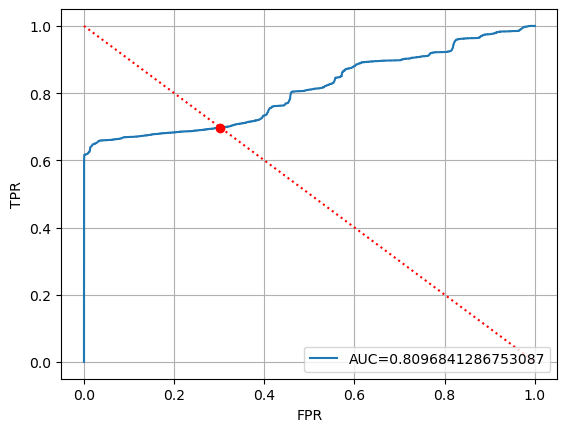

array([5.599038], dtype=float32)

In [31]:
threshold = ROC(y_test,y_pred)
threshold

In [32]:
def print_metrics(y_pred, y_true):
    conf_matrix = confusion_matrix(y_true, y_pred)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print(f'False positive: {FP} \nTrue positive: {TP} \nFalse negative: {FN} \nTrue negative: {TN}')
    print(f'Precision: {100 * precision} \nRecall: {100 * recall}')
    print(f'F1: {F1 * 100}')

def print_detection_percentage(y_pred_int, y_test, anomaly_segments):
    for index, (i, j) in enumerate(anomaly_segments):
        cur_pred = y_pred_int[i:j]
        cur_true = y_test[i:j]
        print(f'Segment number {index} has {np.sum((cur_pred < cur_true).astype(int))} points undetected while total is {len(cur_pred)}')

best: 10.428571428571427 F1: 0.7607341855129465
False positive: 37 
True positive: 6963 
False negative: 4343 
True negative: 78629
Precision: 99.47142857142856 
Recall: 61.58676808774102
F1: 76.07341855129465


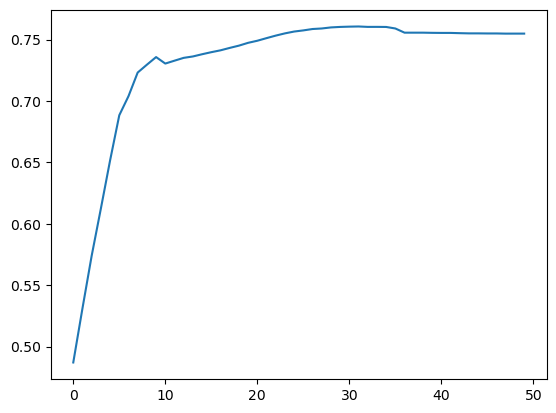

In [33]:
ff = 0
f_history = []
initial_y = 6
best = -1
for inc in np.linspace(0, 7, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)
y_pred_int = (y_pred > best).astype(int)
print_metrics(y_pred_int, y_test)

In [34]:
started = False
anomaly_segments = []
for i in range(len(y_test)):
    if y_test[i] == 1 and not started:
        started = True
        left_side = i
    if y_test[i] == 0 and started:
        started = False
        anomaly_segments.append((left_side, i - 1))

In [35]:
y_pred_int = np.array((y_pred > best).astype(int))
latency_times = []
for index, (i, j) in enumerate(anomaly_segments):
    current_arr = y_pred_int[i: j]
    first_detection = np.where(current_arr == 1)[0]
    if first_detection.shape[0] > 0:
        latency_times.append(first_detection[0])
print(np.mean(latency_times))

115.0


In [36]:
for i, j in anomaly_segments:
    if np.sum(y_pred_int[i: j]) / (j - i) > 0.2:
        y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
print_metrics(y_pred_int, y_test)

False positive: 37 
True positive: 7917 
False negative: 3389 
True negative: 78629
Precision: 99.53482524515967 
Recall: 70.0247656111799
F1: 82.21183800623054


In [37]:
for i, j in anomaly_segments:
    if np.sum(y_pred_int[i: j]) > 0:
        y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
print_metrics(y_pred_int, y_test)

False positive: 37 
True positive: 7917 
False negative: 3389 
True negative: 78629
Precision: 99.53482524515967 
Recall: 70.0247656111799
F1: 82.21183800623054


# Try adjust point

## Point Adjust

best: 7.857142857142857 F1: 0.8289818499466174


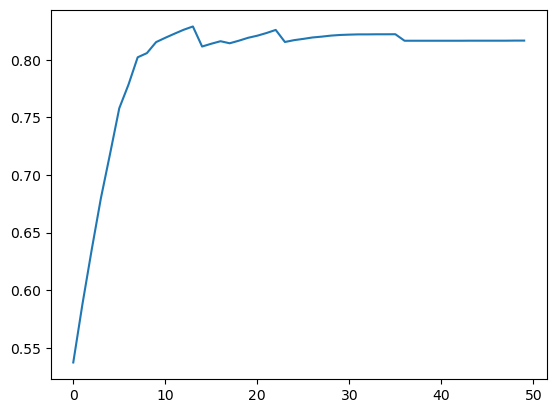

In [38]:
ff = 0
f_history = []
initial_y = 6
best = -1
for inc in np.linspace(0, 7, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) > 0:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

## Point Adjust 20%

best: 11.0 F1: 0.822246455834242


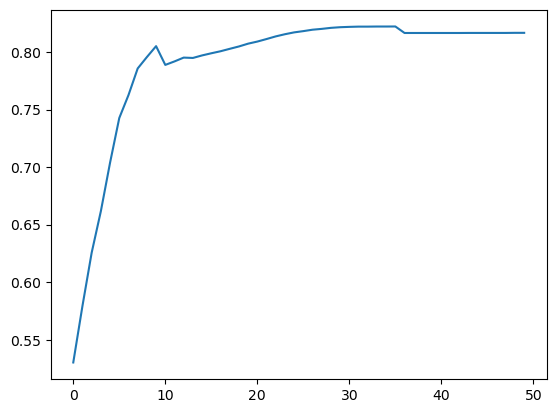

In [39]:
ff = 0
f_history = []
initial_y = 6
best = -1
for inc in np.linspace(0, 7, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) / (j - i) > 0.3:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

## Visualization

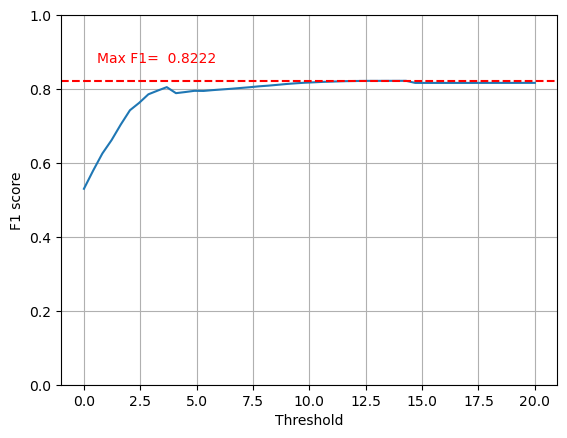

In [40]:
x_vals = 0. + np.linspace(0, 20, 50)
plt.plot(x_vals, f_history)
plt.xlabel('Threshold')
plt.ylabel('F1 score')

max_y = max(f_history)
max_x = np.argmax(f_history)
plt.axhline(y=max_y, color='r', linestyle='--', label='Max Y')
plt.text(0.6, max_y + 0.05, f'Max F1= {max_y: .4f}', color='r')
plt.ylim(0, 1)
plt.grid(True)

# plt.savefig('my_plot.png')

plt.show()

In [41]:
sum1 = sum(p.numel() for p in AE1.parameters() if p.requires_grad)
sum2 = sum(p.numel() for p in AE2.parameters() if p.requires_grad)
sum3 = sum(p.numel() for p in shared_encoder.parameters() if p.requires_grad)
print(sum1 + sum2 - sum3)

723271
